# Machine learn some photometry to classify SEDs
For fitting SEDs with models, it's easy for an experienced eye to immediately see what kind of model is most likely to be appropriate. For example, a "flat-spectrum" source is probably a protoplanetary disk, while something that looks like a blackbody is most likely to simply be a star.

A large database of stars that also contains some basic results from model fitting to each is valuable. It can give a user a quick look at the system properties, for example as a means to estimate the effective temperature, luminosity, etc., and judge whether circumstellar dust is detected.

One possible goal is therefore to arrive at the most appropriate model for a give target. Given a desire to automatically do this for a large number of targets, it would be desirable for the first model tried to be the most appropriate. Computation time is saved, so for example results can be delivered on-the-fly.

The goal here is to do this with only the available photometry. For the vast majority of stars this will be all we have, with no spectra for proper stellar classification or details of silicate features in excesses etc. Not all stars will have the same photometry, so the training and prediction must be done in a way that reflects what we really know.

I suspect a good way to do this, and avoid some other issues, is to do everything with colours. There are no normalisation issues, and then a default set of colours can be used to replace missing data. These default colours would be of a star of some assumed spectral type, and might be guessed from other information already present, for example a spectral type or other photometry (e.g. J-K used to infer B-V). This would then retain some ability to be predictive about stellar type, though this isn't really the goal and for the most part Simbad is a simpler way to get spectral types.

Some transformations that convert optical and near-IR colours would be beneficial, since this could account for missing data. For example, we might use only B and V, but these can come from bright-star, Tycho, APASS, and eventually Gaia catalogues, which spans a very wide range of magnitudes. 2MASS is pretty universal for JHK and goes very deep, though some replacement for bright stars would be nice. At longer wavelengths we can use WISE, IRAS, Spitzer, and Hercshel, with perhaps some contribution from AKARI where WISE is saturated. A relatively small number of sources have mm-wave photometry, and this will not influcence a classification singificantly anyway.

One problem with this approach is that it requires photometry, so sources such as Class 0 protostars that are not detected optically cannot be easily classified.

In [1]:
# so classifier can be changed externally
%load_ext autoreload
%autoreload 2

import glob
import pickle
import numpy as np
from sklearn.neural_network import MLPClassifier
import sklearn.model_selection
import sklearn.metrics
import matplotlib.pyplot as plt
from matplotlib import offsetbox

from sklearn.manifold import TSNE
# import tensorflow as tf

from classifier.photometry import *
from classifier.utils import *

%matplotlib notebook

### Load data
Optionally split out "skipped" data, which is defined in phot_funcs. Current definiton is that more than two colours that are desired but not obtained without interpolation. The model is expected to be better in general when the skipped data are included in the training set, since these are real-world cases that will be encountered frequently in the wild.

In [78]:
# get all the data, labels are one hot vectors
files = glob.glob('labels/*.csv')
# files = ['labels/transition.csv']
print("Files:",[f.split('/')[1] for f in files])
data,labels,sdbids,skip,label_names = get_data(files)

Files: ['absil_2013.csv', 'bright_stars.csv', 'hops.csv', 'howard_2013_.csv', 'rebull_2010.csv', 'shardds.csv', 'sons.csv', 'transition.csv']
Classes: ['class I', 'class II', 'transition', 'debris', 'star']
Kept 464 of 518 (duplicates discarded)


In [79]:
# split into OK and skipped, switch this to do classification for
# targets with partial (False), or full (True) sets of photometry
split_skip = False
if split_skip:
    data_skip = data[skip]
    labels_skip = labels[skip]
    sdbids_skip = sdbids[skip]
    noskip = np.invert(skip)
    data = data[noskip]
    labels = labels[noskip]
    sdbids = sdbids[noskip]
    print('({} skipped)'.format(np.sum(skip)))

labels_nums = [np.argmax(r) for r in labels]
n_labels = labels.shape[1]
data_len = data.shape[1]

print('Data length:',data_len)
for i,label in enumerate(label_names):
    print(label,':',np.sum(labels[:,i]))

print("total:",data.shape[0])

Data length: 8
class I : 60
class II : 71
transition : 36
debris : 141
star : 156
total: 464


<IPython.core.display.Javascript object>


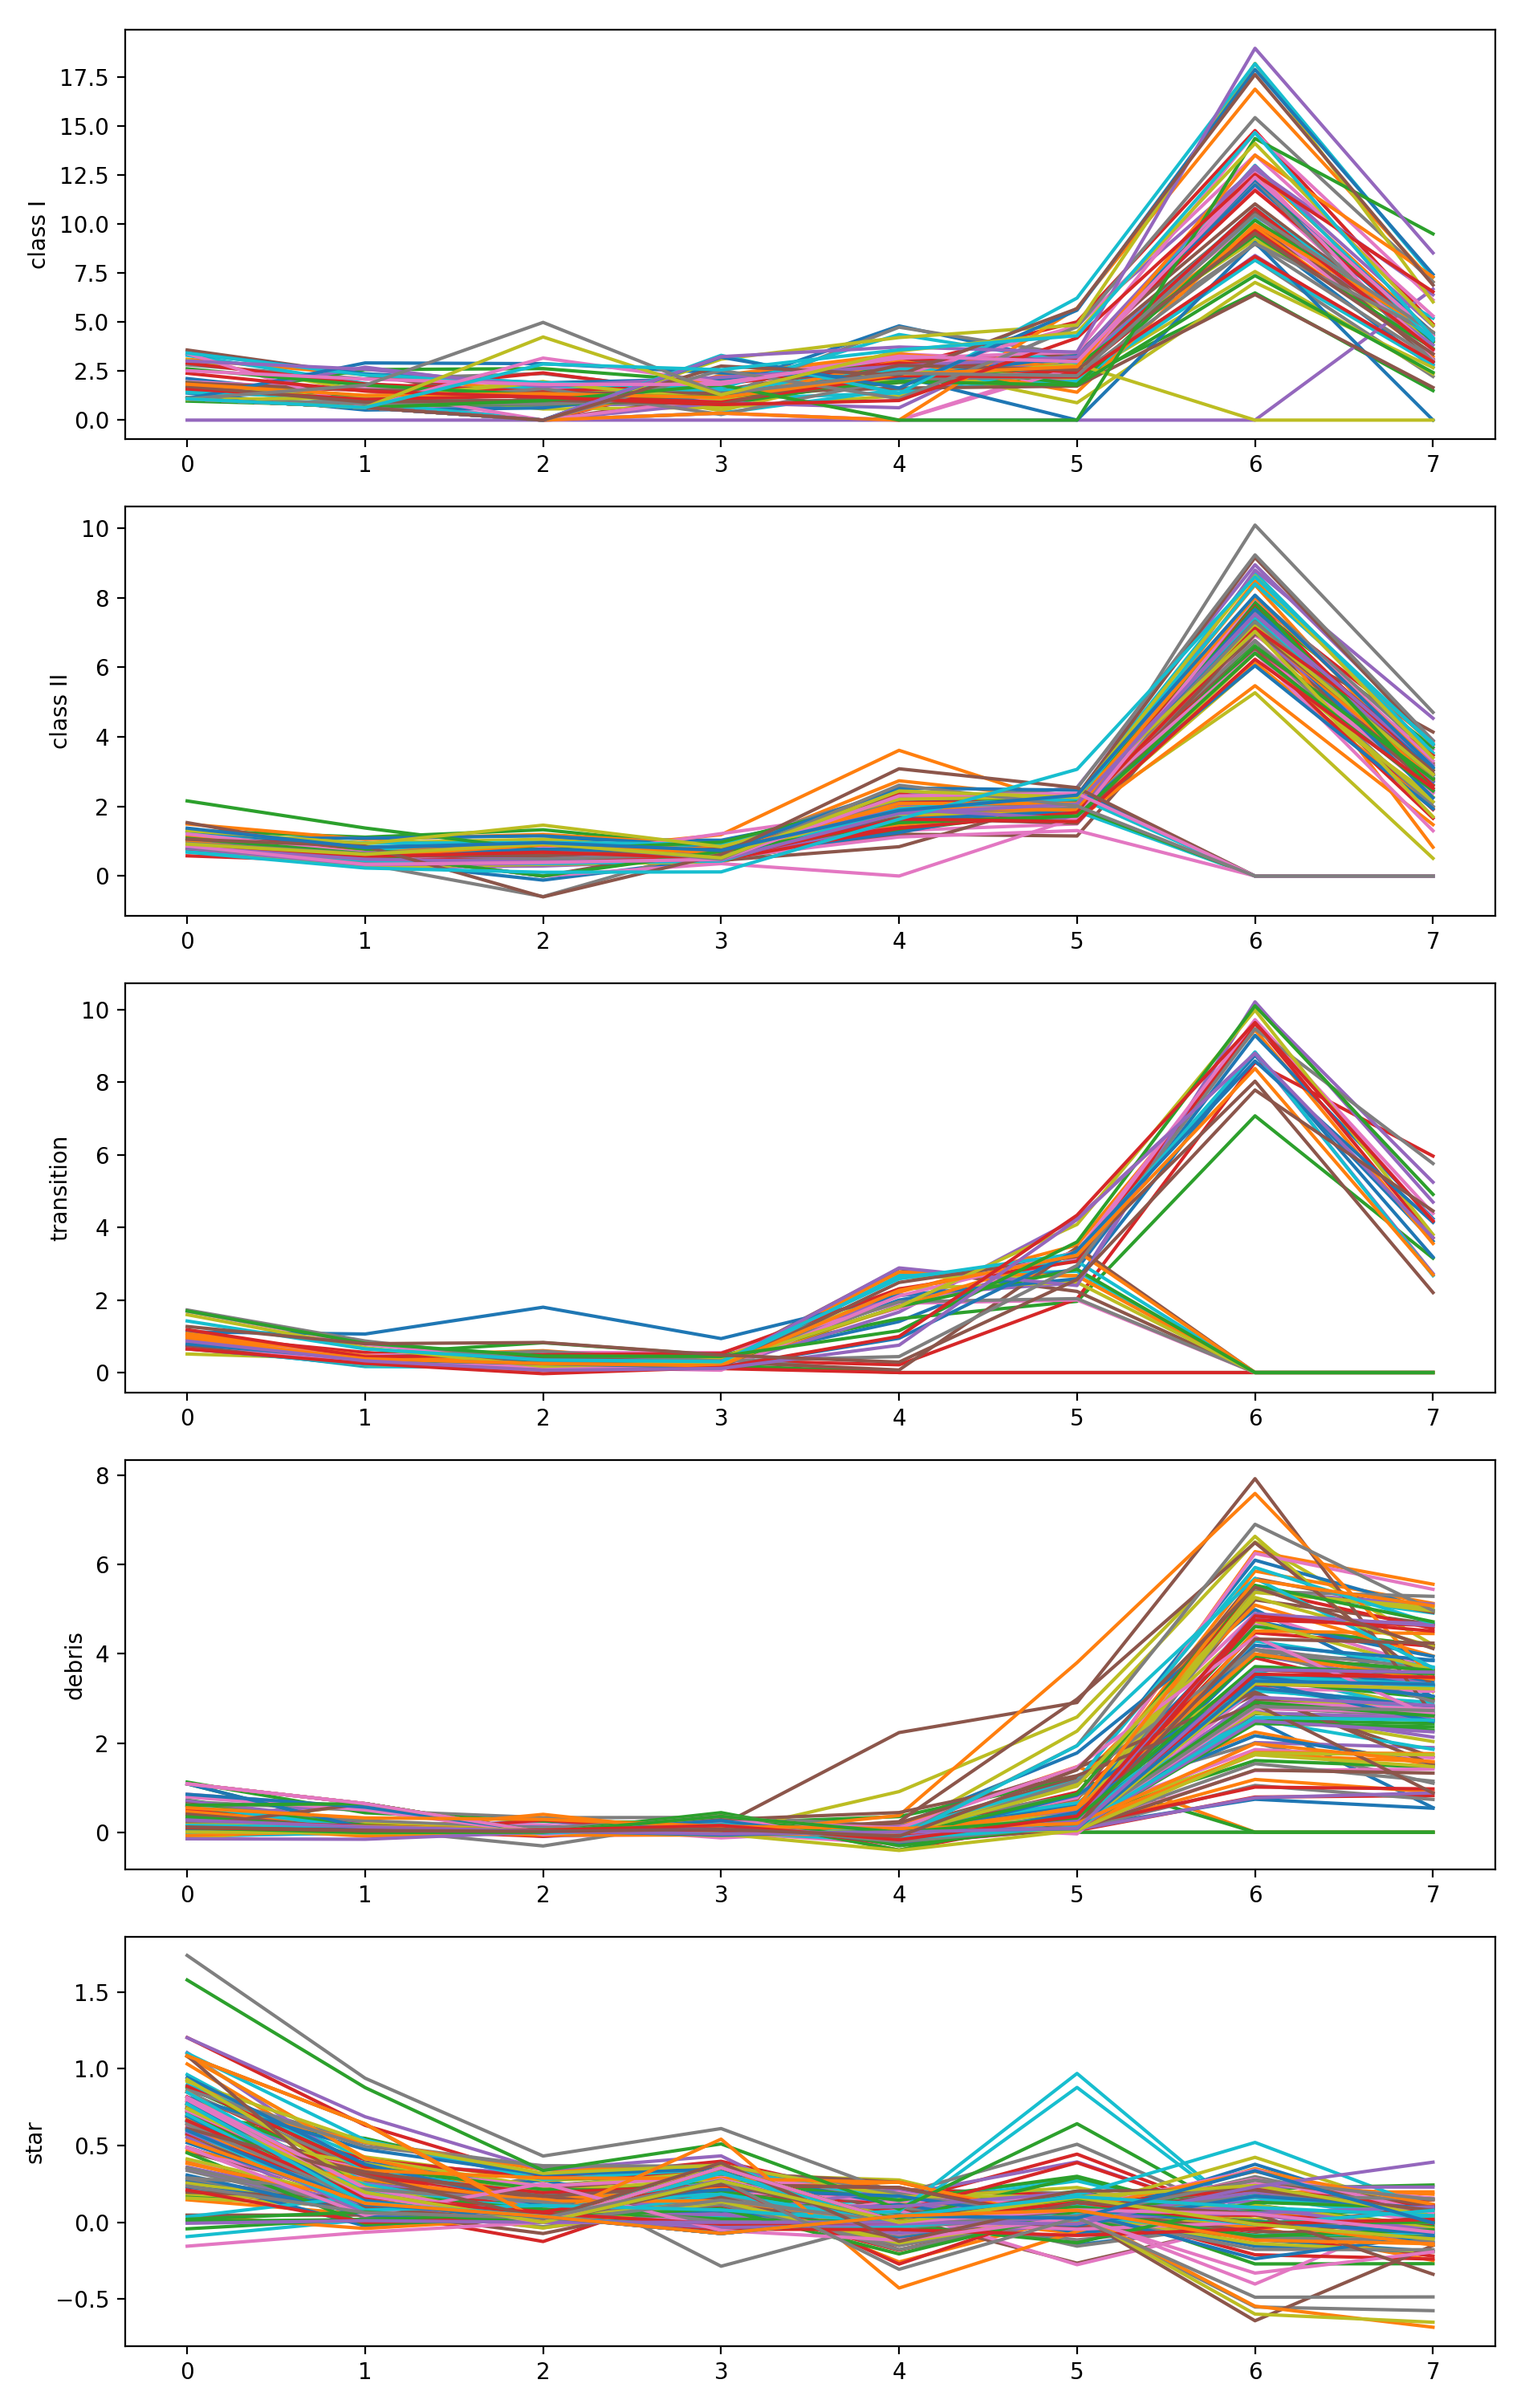

In [80]:
fig,ax = plt.subplots(n_labels,figsize=(9.5,15))
for i in range(n_labels):
    ok = labels[:,i] == 1
    for j,b in enumerate(ok):
        if b and j >= 19:
            l = ax[i].plot(data[j,:],label=sdbids[j])
    ax[i].set_ylabel(label_names[i])
#     ax[i].legend()
    
fig.tight_layout()

### Test-train split
Split the data into training set, and test set for validation.

In [81]:
# split the data, and get numeric labels as one hot arrays
sdbids_train,data_train,labels_train,sdbids_test,data_test,labels_test = split_data(sdbids,data,labels,test_train=0.7)
# get labels as vectors of numbers
labels_train_nums = [np.argmax(r) for r in labels_train]
labels_test_nums = [np.argmax(r) for r in labels_test]
if split_skip:
    labels_skip_nums = [np.argmax(r) for r in labels_skip]

Initial: 464 -> Train: [ 42  49  25  98 109] 323 | Test: [18 22 11 43 47] 141


### Initial model build and evaluation
First a grid search across optimisation parameters to ascertain which model, if any, is best suited. The score, defined as the average fraction of correct predictions when the training set is split several ways, is mostly a bit above 90%.

The results vary from run to run, suggesting that no model is much better than any other. It also doesn't matter too much what the parameters are. Success rates of about 90% are obtained in most cases. Most failures appear to be incomplete photometry rather than a problem with the model.

The stochastic gradient descent seems to have problems converging, but is no better than the others. lbfgs is very fast, but doesn't always minimise very well, sometimes ending up with models that don't return 100% on the training data. adam seems to be the most reliable choice.

In [44]:
if 1:
    # this sets the defaults for things not varied in the grid search
    clf = MLPClassifier(solver='adam', alpha=0.001, hidden_layer_sizes=(10,20,10),
                       tol=1e-6, warm_start=False, max_iter=10000,
                        learning_rate_init=0.001, learning_rate='adaptive')

    grid = [{'solver':['adam'], 'hidden_layer_sizes':[(20,40,20),(10,20,10),(10,10)],
             'alpha':[1e-4,1e-2,0],'learning_rate_init':[0.001,0.01]},
    #         {'solver':['sgd'], 'hidden_layer_sizes':[(10,20,10),(10,10)],
    #          'alpha':[1e-6,1e-4,1e-2,0],'shuffle':[True,False],'learning_rate_init':[0.001,0.01]},
            {'solver':['lbfgs'], 'hidden_layer_sizes':[(20,40,20),(10,20,10),(10,10)],
             'alpha':[1e-4,1e-2,0]}]
    gs = sklearn.model_selection.GridSearchCV(clf,grid,cv=4)
    gs.fit(data_train,labels_train_nums)

    print("Best parameters found on training set:")
    print(gs.best_params_)
    print()
    print("Grid scores on training set:")
    means = gs.cv_results_['mean_test_score']
    stds = gs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters found on training set:
{'alpha': 0.0001, 'hidden_layer_sizes': (20, 40, 20), 'learning_rate_init': 0.001, 'solver': 'adam'}

Grid scores on training set:
0.927 (+/-0.040) for {'alpha': 0.0001, 'hidden_layer_sizes': (20, 40, 20), 'learning_rate_init': 0.001, 'solver': 'adam'}
0.917 (+/-0.065) for {'alpha': 0.0001, 'hidden_layer_sizes': (20, 40, 20), 'learning_rate_init': 0.01, 'solver': 'adam'}
0.913 (+/-0.021) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 20, 10), 'learning_rate_init': 0.001, 'solver': 'adam'}
0.890 (+/-0.145) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 20, 10), 'learning_rate_init': 0.01, 'solver': 'adam'}
0.913 (+/-0.036) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.001, 'solver': 'adam'}
0.917 (+/-0.036) for {'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.01, 'solver': 'adam'}
0.899 (+/-0.067) for {'alpha': 0.01, 'hidden_layer_sizes': (20, 40, 20), 'learning_rate_init': 0.001, 'solver

### Build neural network model
Given the results above, a model is chosen, run, and some metrics are generated:

- The variation in cross-validation score as the number of training samples is changed. The variation within each number of samples, and the variation across the plot, give a good idea of how the results vary.
- The success of this model against the training, test (and skipped if exists) sets.
- A confusion matrix showing where the model tends to make mistakes.

In [85]:
clf = MLPClassifier(solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(20,40,20),
                   tol=1e-6, warm_start=False, max_iter=10000,
                    learning_rate_init=0.001, learning_rate='adaptive')

clf.fit(data_train,labels_train_nums)
print('Step',clf.n_iter_,'loss',clf.loss_)

Step 388 loss 0.10810100891


<IPython.core.display.Javascript object>


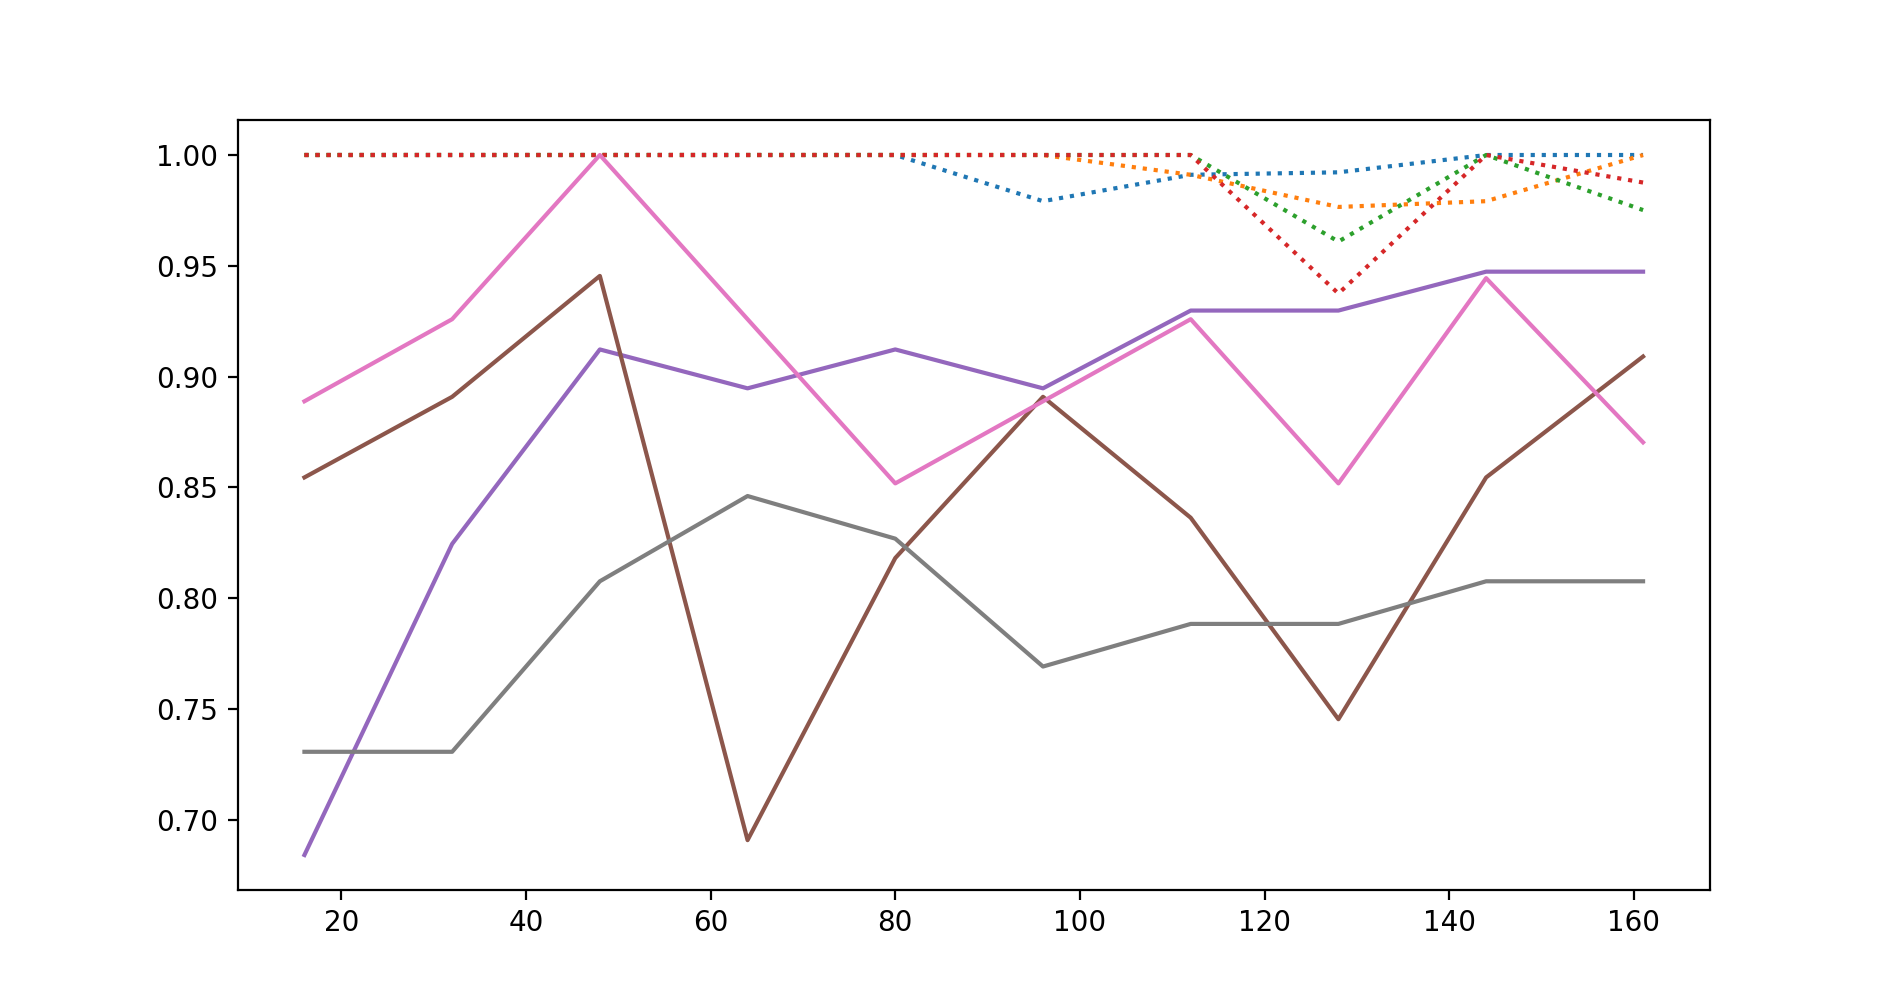

Cross validation: [ 0.88607595  0.89873418  0.79487179  0.84615385]


In [41]:
fig,ax = plt.subplots(figsize=(9.5,5))

# run for all
s = sklearn.model_selection.cross_val_score(clf,data,labels,cv=4,verbose=0)
print('Cross validation:',s)

# and at different numbers
sz,train_score,test_score = sklearn.model_selection.learning_curve(clf,data_train,labels_train_nums,
                                                                  train_sizes=np.linspace(0.1,1,10),
                                      cv=sklearn.model_selection.StratifiedKFold(n_splits=4, shuffle=True))
ax.plot(sz,train_score,':')
ax.plot(sz,test_score)

In [86]:
print('Training set:')
pred = clf.predict(data_train)
model_success(pred,sdbids_train,label_names,labels_train_nums)

print('Test set:')
pred = clf.predict(data_test)
model_success(pred,sdbids_test,label_names,labels_test_nums)

if split_skip:
    print('Skipped set:')
    pred = clf.predict(data_skip)
    model_success(pred,sdbids_skip,label_names,labels_skip_nums)

Training set:
7 sdb-v1-043520.23+223214.6 class II transition
11 sdb-v1-042653.54+260654.4 class II class I
89 sdb-v1-041417.61+280609.6 class II class I
107 sdb-v1-043828.59+261049.6 class I class II
119 sdb-v1-041426.32+280601.6 class II class I
158 sdb-v1-043552.78+225423.1 transition class I
159 sdb-v1-041357.38+291819.3 class II class I
188 sdb-v1-044008.00+260525.4 class I class II
197 sdb-v1-053640.40-061333.4 transition class II
204 sdb-v1-041851.12+281433.4 star debris
207 sdb-v1-053558.25-063643.1 class II transition
280 sdb-v1-053640.76-061108.3 class I transition
This set: 12/323= 3.7% failed
Test set:
9 sdb-v1-112205.29-244639.5 transition debris
19 sdb-v1-042838.93+265135.3 debris class I
46 sdb-v1-053550.47-055142.2 debris transition
50 sdb-v1-053328.52-051726.3 class II transition
51 sdb-v1-040236.74-001608.1 class II debris
66 sdb-v1-053537.34-062326.4 star transition
68 sdb-v1-014404.08-155614.9 class II debris
75 sdb-v1-053400.35-053543.4 star debris
101 sdb-v1-04403

             precision    recall  f1-score   support

    class I       1.00      0.94      0.97        18
   class II       0.81      1.00      0.90        22
 transition       0.80      0.36      0.50        11
     debris       0.95      0.91      0.93        43
       star       0.92      1.00      0.96        47

avg / total       0.91      0.91      0.91       141



<IPython.core.display.Javascript object>


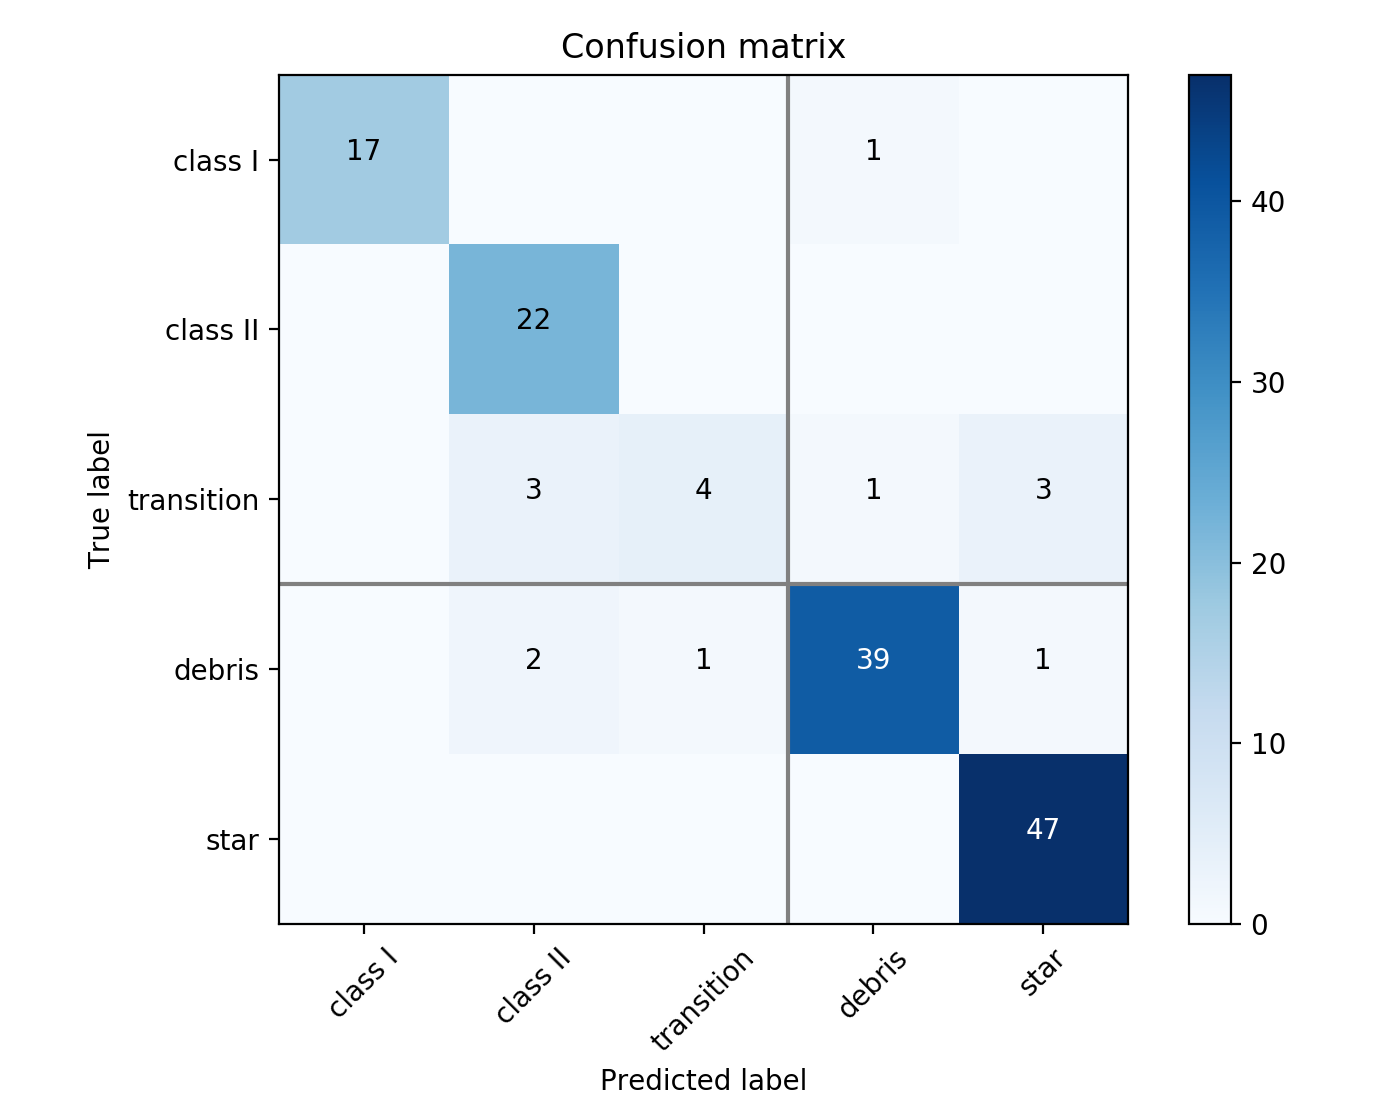

In [87]:
# classification report using test set
y_true, y_pred = labels_test_nums, clf.predict(data_test)
print(sklearn.metrics.classification_report(y_true, y_pred,target_names=label_names))

# confusion matrix
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm,label_names,lines=[2.5])

             precision    recall  f1-score   support

    class I       1.00      0.35      0.52        17
   class II       0.50      0.67      0.57         3
 transition       0.00      0.00      0.00         3
     debris       0.97      0.81      0.88        36
       star       0.91      1.00      0.95        91

avg / total       0.91      0.85      0.86       150



<IPython.core.display.Javascript object>


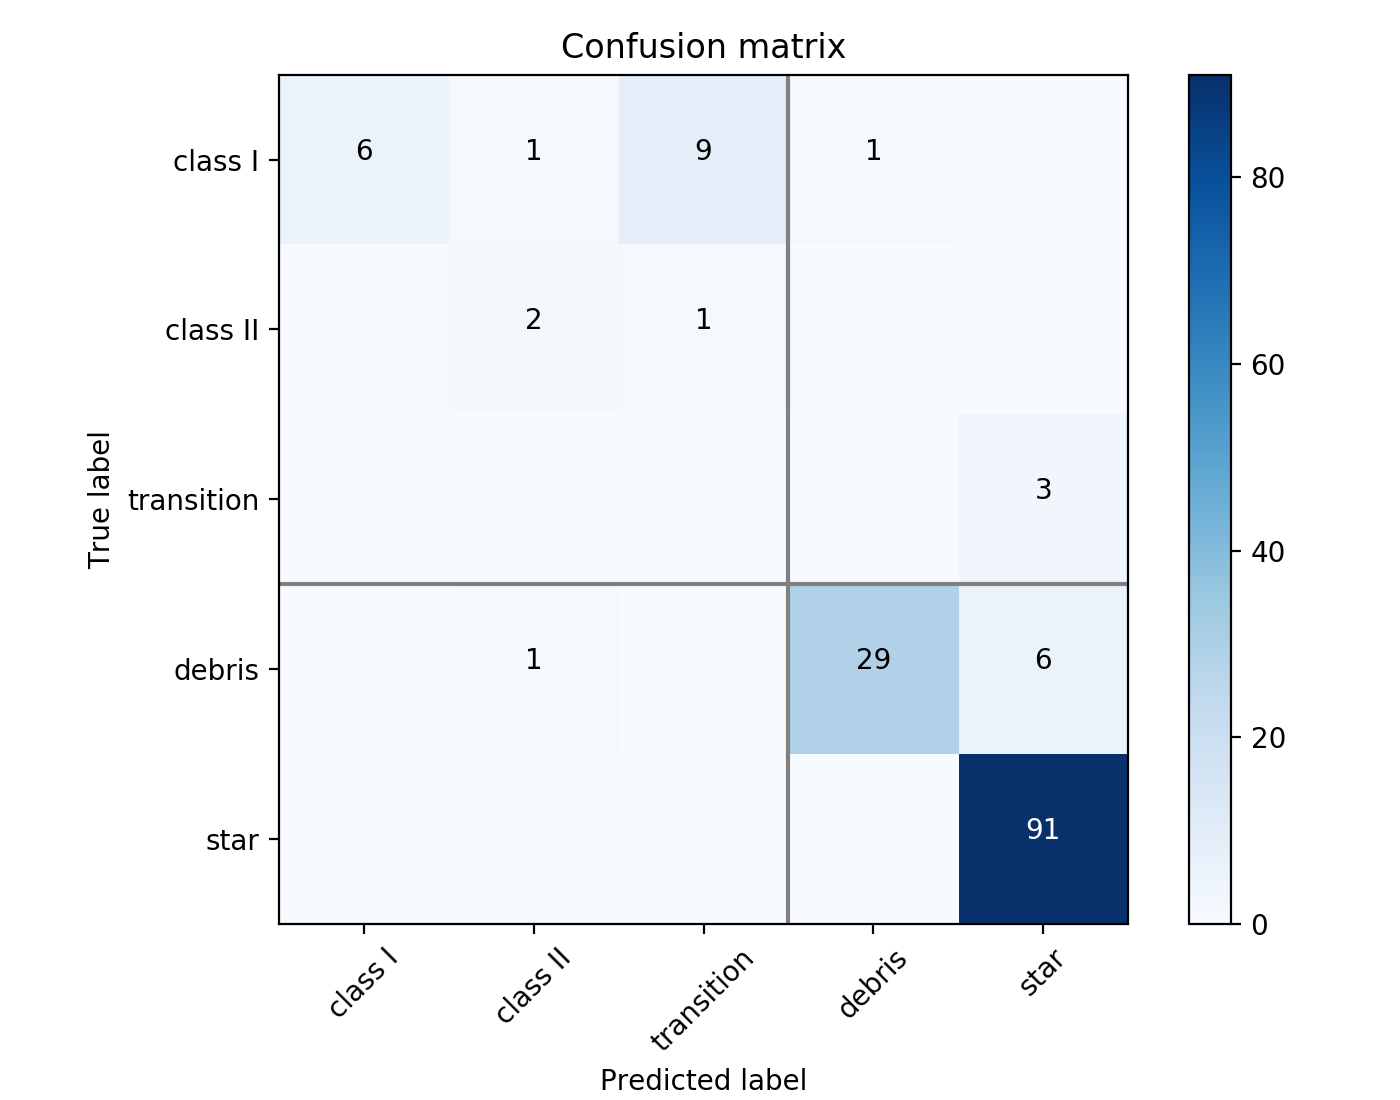

In [76]:
# same again for skipped, showing how well we did in cases with less than full data
# when the model was trained only on full data
if split_skip:
    y_true, y_pred = labels_skip_nums, clf.predict(data_skip)
    print(sklearn.metrics.classification_report(y_true, y_pred,target_names=label_names))    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm,label_names,lines=[2.5])

### Conclusion

A neural net can do a reasonable (~90% success) job of classifying SEDs given a handful of photometry. The rate isn't as high as it might be, but this is largely down to incomplete photometry.

When the model is wrong, it tends to be so for Class II's, which get called Class I or debris. Given that these can look similar this isn't surprising. Similarly, Class I's can be called Class II's.

If the data would have been skipped (based on the metrics noted above) then it's much better to have trained the model for this case, in which the chance of successful classification is around 90%. If the data wouldn't have been skipped, it's better (~95% success) to have trained the model only on samples that wouldn't have been skipped.

Thus, this notebook should be run twice, once for all data, including that which could have been skipped, and this is the general model. Another run with the skipped data removed generates the model that is used on data that won't be skipped.

In [88]:
# save the model, 'full' is for when we have lots of data, 'partial' when we don't
if split_skip:
    name = '../../classifier/phot-nn-full-classifier.pkl'
else:
    name = '../../classifier/phot-nn-partial-classifier.pkl'
    
with open(name,'wb') as f:
    pickle.dump(label_names,f)
    pickle.dump(clf,f)

### Extras
The basic matrix multiplication model below is OK, but not as good as is possible with the neural networks.

The equivalent tensorflow model below obtains similar success rates, but seems to do so more reliably. It uses the Adagrad optimisation method, which isn't an option for sklearn (but might be similar to adam).

In [46]:
p=download_photometry('sdb-v1-151559.17+004746.9')
c=Colours(phot=p)
# c.__dict__

In [89]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(labels_train_nums[i]),
                 color=plt.cm.Set1(labels_train_nums[i] / 4.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

99


<IPython.core.display.Javascript object>


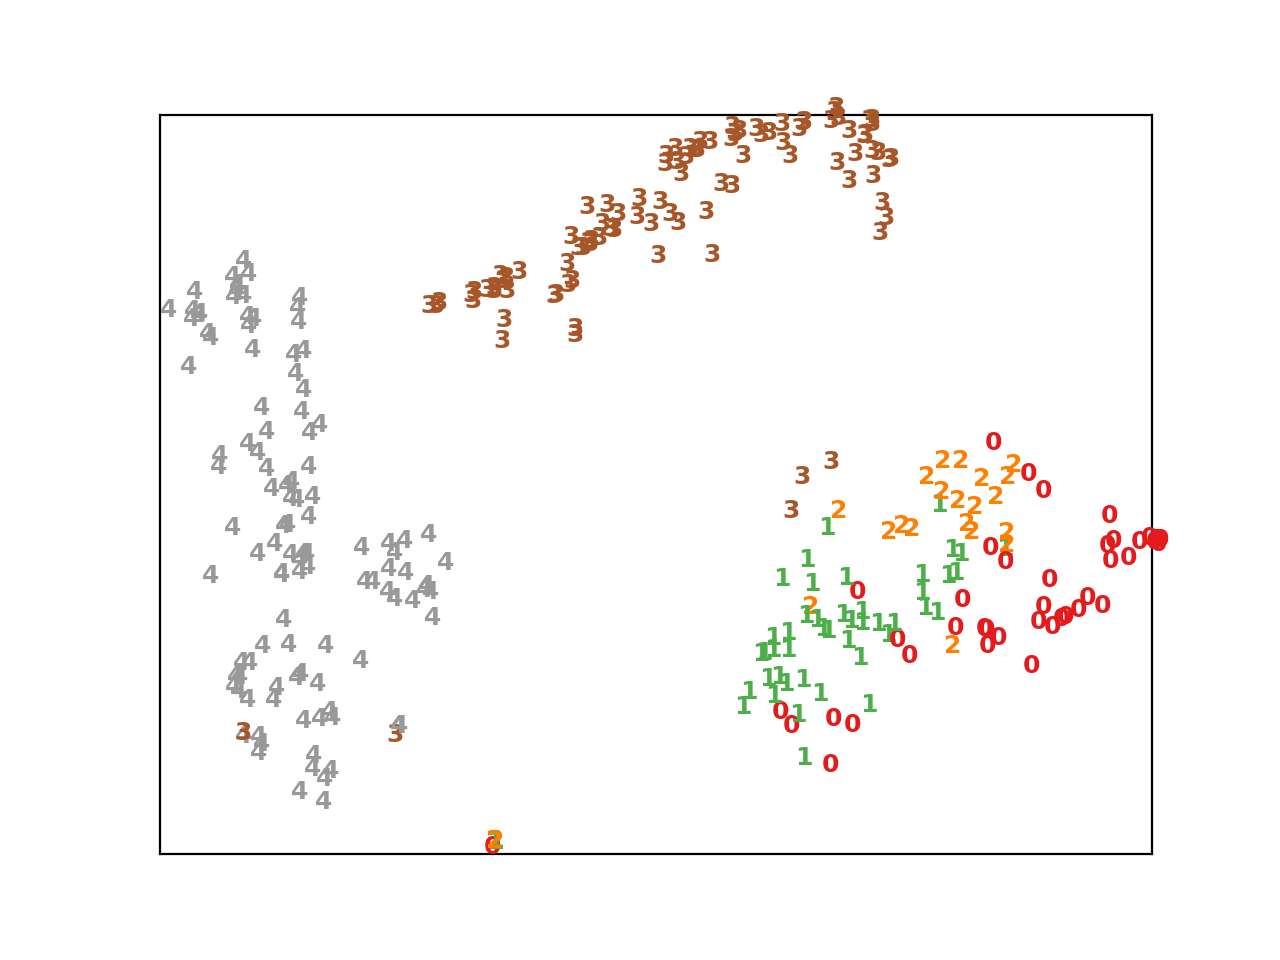

In [90]:
tsne = TSNE(n_components=2,init='pca',learning_rate=100,n_iter=2000)
x = tsne.fit_transform(data_train)
print(tsne.n_iter_final)

plot_embedding(x)

In [ ]:
# a basic tensorflow model, just a matrix multiplication
x = tf.placeholder(tf.float32, [None, data_len])
W = tf.Variable(tf.zeros([data_len, n_labels]))
b = tf.Variable(tf.zeros([n_labels]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, n_labels])

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for _ in range(5000):
  sess.run(train_step, feed_dict={x: data_train, y_: labels_train})

fig,ax = plt.subplots(figsize=(9.5,6))
for i in range(n_labels):
    ax.plot(range(data_len),W.eval()[:,i] + b.eval()[i],label=label_names[i])
    
ax.legend(loc=6,fontsize='large')
c = Colours()
ax.set_xticks(range(data_len))
_ = ax.set_xticklabels(c.wanted,rotation=45)

print('Training set:')
label_pred = tf.argmax(y,1)
pred = sess.run(label_pred, feed_dict={x: data_train})
model_success(pred,sdbids_train,label_names,labels_train_nums)

print('Test set:')
pred = sess.run(label_pred, feed_dict={x: data_test})
model_success(pred,sdbids_test,label_names,labels_test_nums)

In [ ]:
# tensorflow nn

# Define training input functions
def get_train_inputs():
    x = tf.constant(data_train)
    y = tf.constant(labels_train_nums)
    return x, y

# Define the testing inputs
def get_test_inputs():
    x = tf.constant(data_test)
    y = tf.constant(labels_test_nums)
    return x, y

feature_columns = [tf.contrib.layers.real_valued_column("", dimension=data_len)]

# Build 3 layer DNN with 10, 20, 10 units respectively.
classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[10,20,10],
                                            n_classes=n_labels,
                                            model_dir="./tf")

classifier.fit(input_fn=get_train_inputs, steps=5000)

print('Training set:')
pred = list(classifier.predict_classes(input_fn=get_train_inputs))
model_success(pred,sdbids_train,label_names,labels_train_nums)

print('Test set:')
pred = list(classifier.predict_classes(input_fn=get_test_inputs))
model_success(pred,sdbids_test,label_names,labels_test_nums)